In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
#!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [2]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where (date_time >= NOW() - '18 hour'::INTERVAL) and hashtags is not null and hashtags != 'None';'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)
len(df)

16041

In [3]:
df = df[~df['hashtags'].str.contains('amp')]
df = df[~df['hashtags'].str.contains('job|hiring|sales|retail|clerical')]
df = df[~df['hashtags'].str.contains('dallas|plano|irving|richardson|garland|allen|odessa|midland|sanfrancisco|losangeles|irvine|garland')]

In [4]:
len(df)

13128

In [5]:
df[~df['location'].str.contains('.ca|california')][~df['location'].str.contains('.tx|texas')]

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,index,cleaned_tweet,created_at,date,date_time,hashtags,location,time,tweet_content,created_datetime,year,month,day,hour
3,3,watching the #xboxe3 briefing live from the ga...,Sun Jun 11 22:20:25 +0000 2017,2017-06-11,2017-06-11 22:20:25,xboxe3,galen center (gec),22:20:25,watching the #xboxe3 briefing live from the ga...,2017-06-11 22:20:25,2017,6,11,22
13,13,when you're getting hit on at work by some #ba...,Sun Jun 11 22:20:51 +0000 2017,2017-06-11,2017-06-11 22:20:51,babadook,lookout,22:20:51,when you're getting hit on at work by some #ba...,2017-06-11 22:20:51,2017,6,11,22
38,38,rock and roll babywhen famous band like gun's ...,Sun Jun 11 22:21:42 +0000 2017,2017-06-11,2017-06-11 22:21:42,whiskyagogo,whisky a go go,22:21:42,rock and roll baby🎸when famous band like gun's...,2017-06-11 22:21:42,2017,6,11,22
39,39,#wodlive17 preparations &amp; tech rehearsal i...,Sun Jun 11 22:21:43 +0000 2017,2017-06-11,2017-06-11 22:21:43,wodlive17 thisiswod worldofdance,universal citywalk,22:21:43,#wodlive17 preparations &amp; tech rehearsal i...,2017-06-11 22:21:43,2017,6,11,22
52,52,the #xboxe3 press conference live from the gal...,Sun Jun 11 22:22:12 +0000 2017,2017-06-11,2017-06-11 22:22:12,xboxe3 e32017,galen center (gec),22:22:12,the #xboxe3 press conference live from the gal...,2017-06-11 22:22:12,2017,6,11,22
65,65,went heavy on the front squats. 5x3 @ 205# the...,Sun Jun 11 22:22:33 +0000 2017,2017-06-11,2017-06-11 22:22:33,205 245 liftheavy staytuned venicebeach vbc,gold's gym,22:22:33,went heavy on the front squats. 5x3 @ 205# th...,2017-06-11 22:22:33,2017,6,11,22
112,112,never switch sides 🤘 #benzfam,Sun Jun 11 22:24:21 +0000 2017,2017-06-11,2017-06-11 22:24:21,benzfam,universal music publishing group,22:24:21,never switch sides 🤘🏾 #benzfam https://t.co/xa...,2017-06-11 22:24:21,2017,6,11,22
157,157,joy rich x #madela,Sun Jun 11 22:26:01 +0000 2017,2017-06-11,2017-06-11 22:26:01,madela,la live,22:26:01,joy rich x @snoopdogg #madela https://t.co/g...,2017-06-11 22:26:01,2017,6,11,22
165,165,wild west entertainment at the #stuntshow. mor...,Sun Jun 11 22:26:09 +0000 2017,2017-06-11,2017-06-11 22:26:09,stuntshow mayfair ghosttownalive knottsberryf...,knott's berry farm,22:26:09,wild west entertainment at the #stuntshow. mor...,2017-06-11 22:26:09,2017,6,11,22
186,186,🆕 new arrival!🆕 look what we just got! availab...,Sun Jun 11 22:26:44 +0000 2017,2017-06-11,2017-06-11 22:26:44,marvel sfgiants,giants dugout store,22:26:44,🆕 new arrival!🆕 look what we just got! availab...,2017-06-11 22:26:44,2017,6,11,22


In [6]:
ca_df = df[df['location'].str.contains('.ca|california')]
tx_df = df[df['location'].str.contains('.tx|texas')]

In [7]:
def word_cloud(state = None): 
    
    state = state.lower()
    state_df = df[df['location'].str.contains('.{}'.format(state))]
    words = state_df['hashtags'][(state_df['hashtags'].isnull() == False) & (state_df['hashtags'] != 'None')]
    stopwords = set(STOPWORDS)
    #stopwords.add("dallas")
    #stopwords.add("sanfrancisco")
    #stopwords.add("losangeles")
    #stopwords.add("sacramento")
    #stopwords.add("irvine")
    #stopwords.add("garland")
    #stopwords.add("allen")
    #stopwords.add("irving")
    #stopwords.add("plano")
    #stopwords.add("richardson")
    #stopwords.add("midland")
    #stopwords.add("odessa")
    wc = WordCloud(width=1600, height=800, background_color='white', \
                   relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))


    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return


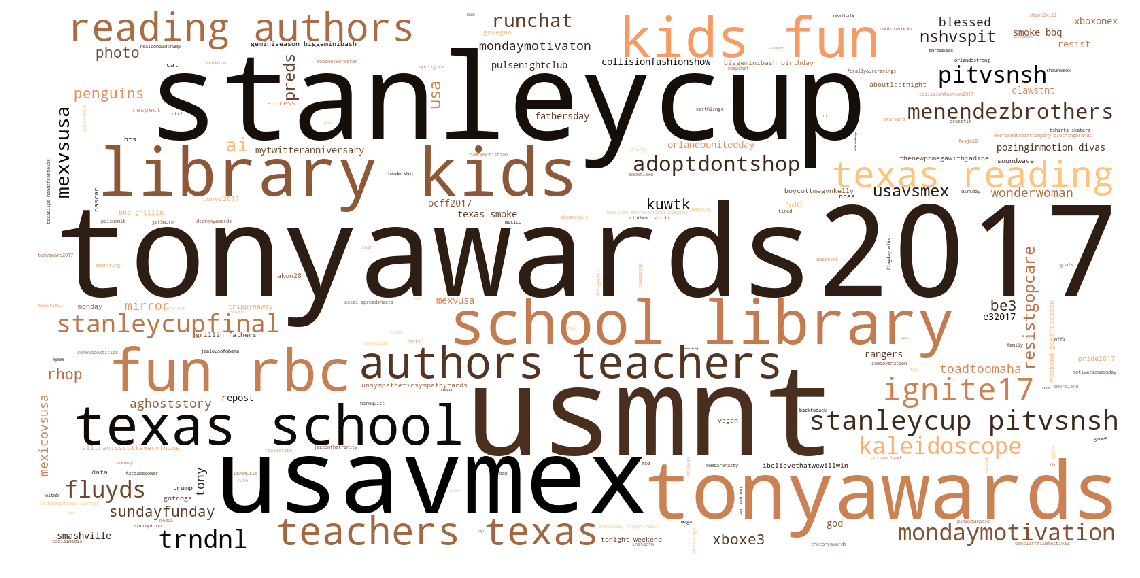

In [8]:
word_cloud('TX')

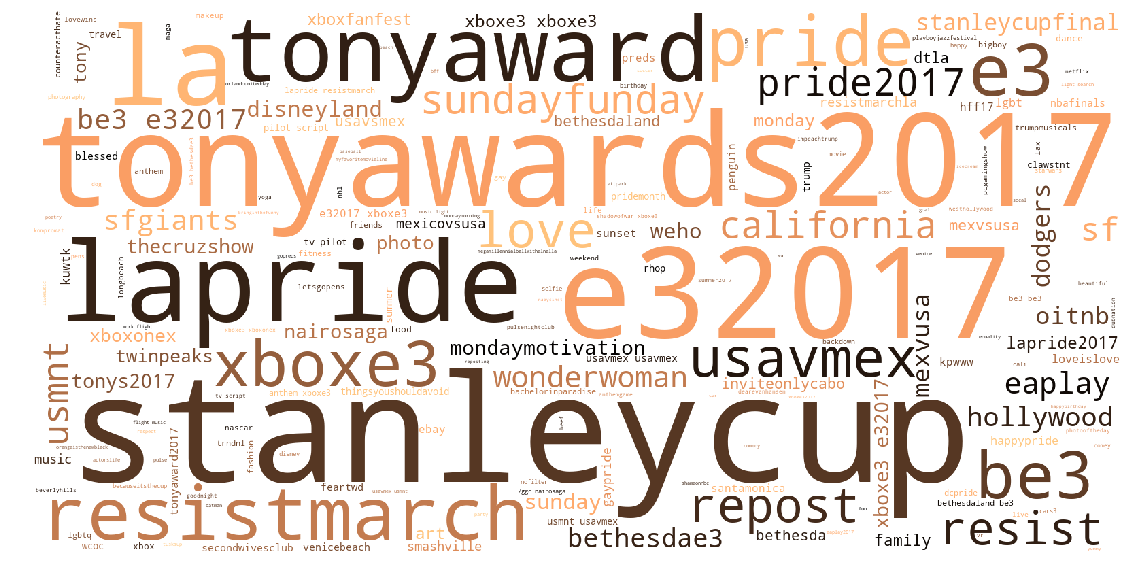

In [9]:
word_cloud('CA')

In [10]:
hastages_series = df['hashtags']
len(hastages_series)

13128

In [11]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec = count_vectorizer.fit_transform(hastages_series)
#hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
#r.set('hashtags_countvec_fit_temp', hashtags_countvec)
#hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [12]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = 0.1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-11 22:20:21 
 end time:   2017-06-12 16:20:11 
 total hours:  17 
 time lag:  0:15:00 
 time gap:  0:06:00 
 time windows:  180


In [13]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

In [14]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .30)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    arr_all = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        #arr_all.append(subset.mean())
        start_time += time_gap
    arr = np.array(arr)  
    #arr_all = np.array(arr_all) 
    grad = np.gradient(arr)
    #grad2 = np.gradient(grad)
    #tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spike = []
    trend = np.argwhere(grad>0).reshape(1,-1)[0]
    trend_group = group_consecutives(trend)
    trend_group2 = [i for i in trend_group if (len(i) > 6)]
    spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
    spike = np.array(spike)
    spk1 = [i[0] for i in spike[0]]
    spk2 = [i[1] for i in spike[0]]
        
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    #plt.plot(grad2, label='grad2 Slope')
    for j,k in zip(spk1,spk2):
        spike1 = (min(df['created_datetime']) + time_gap * j) 
        spike1 = spike1.replace(tzinfo=from_zone)
        spike1_et = spike1.astimezone(to_zone)
        spike1_et = spike1_et.strftime(time_format)
       
        spike2 = (min(df['created_datetime']) + time_gap * k) 
        spike2 = spike2.replace(tzinfo=from_zone)
        spike2_et = spike2.astimezone(to_zone)
        spike2_et = spike2_et.strftime(time_format)           
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spike1_et))
        plt.axvspan(j, k, alpha=0.5, color='red')
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  arr, grad, list((hashtag,len(spike),spike))

In [15]:
hashtag_freq_df = pd.DataFrame({'hashtag': count_vectorizer.get_feature_names(), 'occurrences':np.asarray(hashtags_countvec.sum(axis=0)).ravel().tolist()})
hashtag_freq_df['frequency'] = hashtag_freq_df['occurrences']/np.sum(hashtag_freq_df['occurrences'])
hashtag_freq_df.sort_values(by = 'occurrences',ascending = False, inplace = True)

In [16]:
hashtag_freq_df.head(20)

,hashtag,occurrences,frequency
12412,xboxe3,301,0.011324
3197,e32017,287,0.010797
10260,stanleycup,265,0.009970
11701,usavmex,252,0.009480
1021,be3,214,0.008051
11300,tonyawards2017,210,0.007900
7881,nowplaying,184,0.006922
2537,cubevenue,177,0.006659
11298,tonyawards,156,0.005869
6129,lapride,153,0.005756


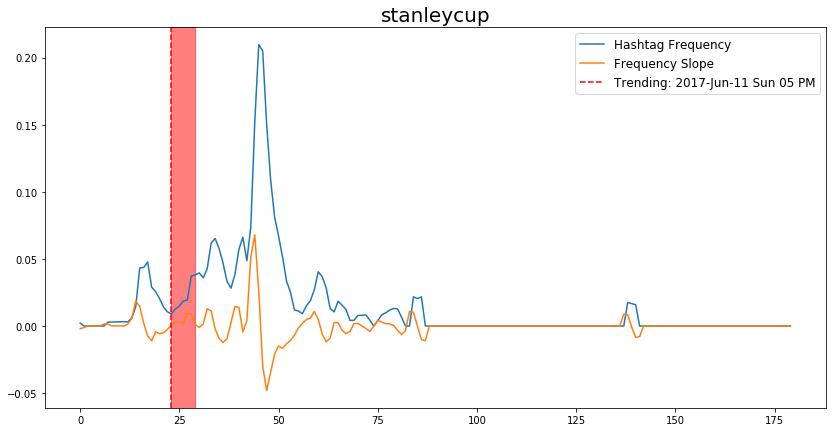

In [19]:
arr, grad, spike = hashtag_trend('stanleycup')

In [21]:
grad

array([ -2.06611570e-03,  -1.03305785e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.44508671e-03,   1.47492625e-03,   7.46701337e-05,
         9.74007903e-05,   9.31463869e-05,  -4.79368001e-05,
         1.38110875e-03,   5.68022071e-03,   1.86862048e-02,
         1.45902608e-02,   2.19246224e-03,  -7.28299844e-03,
        -1.10849553e-02,  -4.30779172e-03,  -5.71701671e-03,
        -4.95198079e-03,  -2.56620257e-03,   1.12545018e-03,
         2.90290290e-03,   2.99013048e-03,   2.25442834e-03,
         9.24274034e-03,   9.37369725e-03,   1.17849637e-03,
        -1.07973189e-03,   1.55254521e-03,   1.28883547e-02,
         1.12672322e-02,  -1.96877590e-03,  -9.14828509e-03,
        -1.22590657e-02,  -9.37590351e-03,   2.61445503e-03,
         1.45551111e-02,   1.38481112e-02,  -4.34294295e-03,
         3.91091551e-03,   5.16945142e-02,   6.78320070e-02,
         2.64428877e-02,  -2.99370103e-02,  -4.80299320e-02,
        -3.43442521e-02,

In [20]:
spike

['stanleycup', 1, array([[[23, 29]]])]

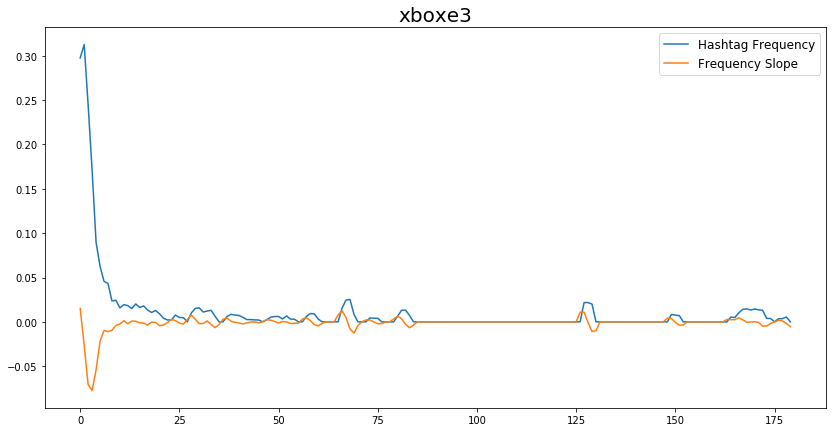

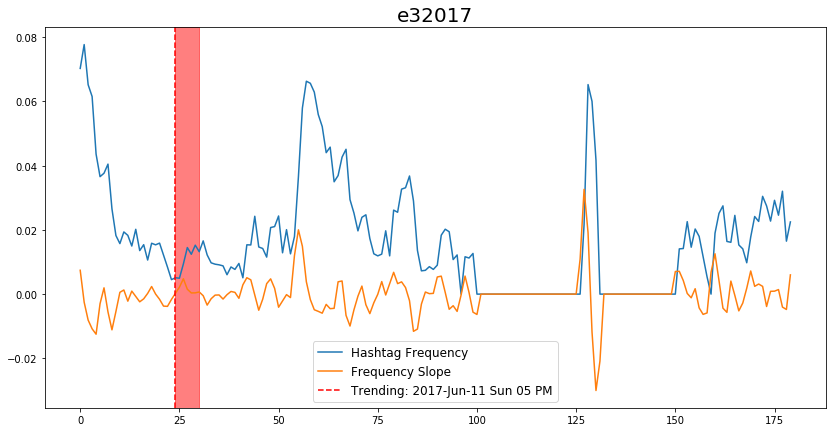

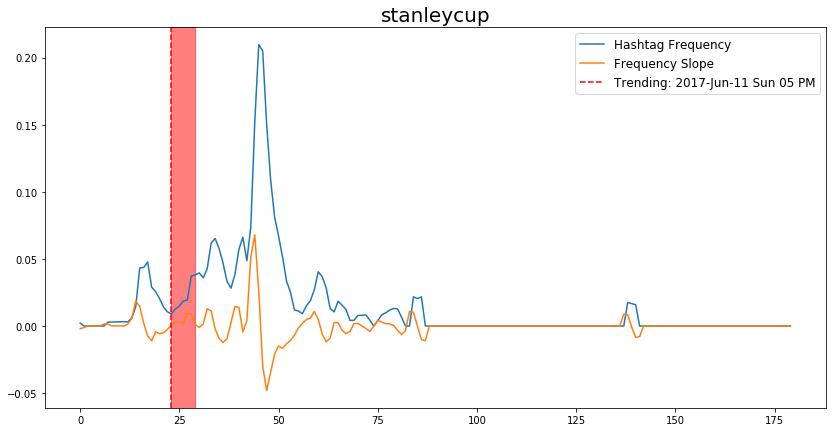

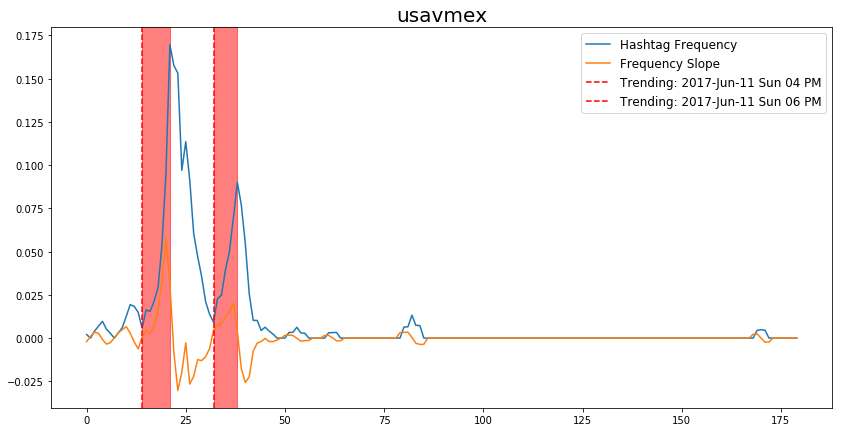

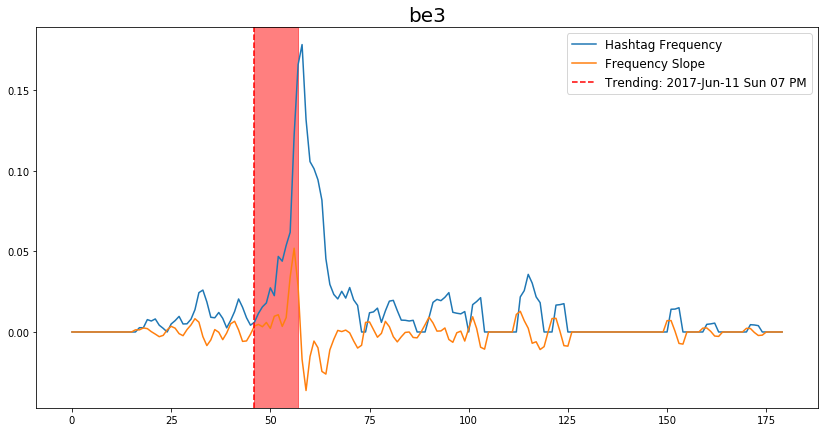

In [18]:
a = [hashtag_trend(i) for i in (hashtag_freq_df['hashtag'].head(5))]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def svd_variance(svd_model, col_index):
    
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(svd_model.components_)+1)]
    components = pd.DataFrame(np.round(svd_model.components_, 4), columns=col_index)
    ratios = svd_model.explained_variance_ratio_.reshape(len(svd_model.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (24,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar',legend='False');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    ax.legend_.remove()


    # Display the explained variance ratios
    for i, ev in enumerate(svd_model.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

In [ ]:
svd_variance(svd, tfd_word_index)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


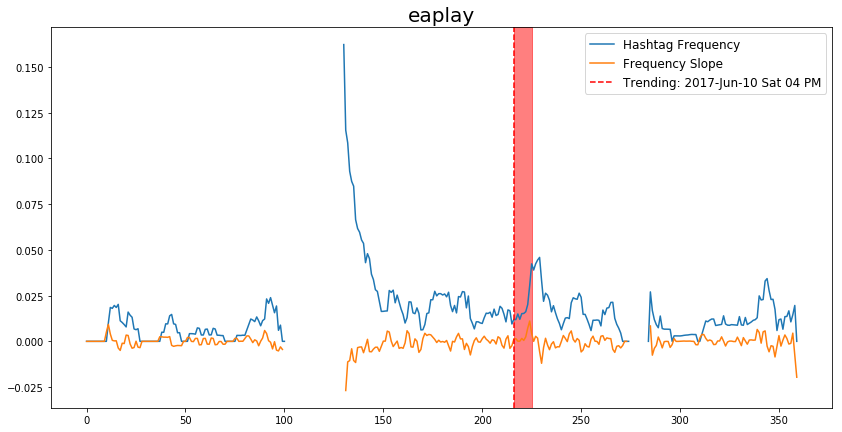

In [162]:
arr, grad, a = hashtag_trend('eaplay')

In [148]:
trend = np.argwhere(grad>0).reshape(1,-1)[0]
trend_group = group_consecutives(trend)
trend_group2 = [i for i in trend_group if (len(i) > 6)]
spike = []
spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
spike = np.array(spike)
spk1 = [i[0] for i in spike[0]]
spk2 = [i[1] for i in spike[0]]
print(spk1)
print(spk2)

[170, 216, 300, 310]
[176, 225, 306, 316]


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [ ]:
plt.plot(np.gradient(nbafinals_grad))

In [ ]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  arr, grad

In [ ]:
arr, grad = hashtag_trend('hiring')

In [ ]:
svd_variance(svd, tfd_word_index)